##### Copyright 2021 The TensorFlow Quantum Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Variational quantum memory for training quantum neural networks

Author : Alexander Zlokapa

Created : 2021-Jun-23

Last updated : 2021-Jun-23

In this tutorial, we use a shallow circuit prepared by an entangling quantum generative adversarial network ([EQ-GAN](https://arxiv.org/abs/2105.00080)) that loads an entire classical dataset in superposition. Although the dataset representation is *approximate* and does not correspond to an exact superposition, it can be used effectively in quantum machine leanring. In particular, we show how the variational quantum random access memory (QRAM) is a useful primitive to speed up training of a quantum neural network ([QNN](https://arxiv.org/pdf/1802.06002.pdf)) on a classification task.

## Setup

Install TensorFlow and TensorFlow Quantum.

In [ ]:
!pip install -q tensorflow==2.7.0
!pip install -q tensorflow-quantum

     |████████████████████████████████| 394.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 20.6MB/s 
     |████████████████████████████████| 471kB 41.0MB/s 
     |████████████████████████████████| 2.9MB 18.7MB/s 
     |████████████████████████████████| 7.8MB 5.4MB/s 
     |████████████████████████████████| 1.3MB 30.4MB/s 
     |████████████████████████████████| 5.6MB 18.8MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 92kB 9.8MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 389kB 50.0MB/s 
     |████████████████████████████████| 1.5MB 35.9MB/s 


Import the modules required for preparing the data, quantum neural network, and visualization.

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import collections
import itertools

Since TensorFlow Quantum is compatible with a hardware backend, we show how a physical device on Quantum Engine can replace the simulated backend.

In [ ]:
hardware_backend = False

if hardware_backend:
    project_id = 'PROJECT_ID'
    engine = cirq.google.Engine(project_id=project_id)
    testsamplerxmon_rainbow = engine.sampler(processor_id=['PROCESSOR_ID'], gate_set=cirq.google.XMON)
    backend = testsamplerxmon_rainbow
else:
    backend = None

## 1 Load variational QRAM

### 1.1 Prepare classical dataset
We'll prepare a classification dataset with two Gaussian-distributed peaks to demonstrate the variational QRAM. First, the classical dataset is generated.

In [ ]:
# create 2-peak dataset
def create_data(seed, n, dataset_size=100):
    np.random.seed(seed)
    # sample data from Gaussian
    data0_raw = np.random.normal(2**(n-1), scale=2, size=dataset_size)
    bins = np.arange(2**n + 1).astype(np.float64)
    bins[-1] = np.inf
    counts0, _ = np.histogram(data0_raw, bins=bins)
    data0 = np.clip(np.floor(data0_raw), 0, 2**n - 1)

    data1_raw = np.random.normal(2**(n-2), scale=1, size=dataset_size)
    counts1, _ = np.histogram(data1_raw, bins=bins)
    data1 = np.clip(np.floor(data1_raw), 0, 2**n - 1)
    
    return data0, data1

Let's prepare a dataset of 120 examples over the numbers $\{0, 1, \dots, 15\}$ and visualize the two Gaussian distributions.

In [ ]:
# create circuits from dataset (for sampling)
size = 120
n = 4 # number of qubits
data0, data1 = create_data(0, n, dataset_size=size)

Classical dataset probabilities


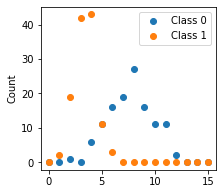

In [ ]:
bins = np.arange(2**n + 1).astype(np.float64)
bins[-1] = np.inf
probs0, _ = np.histogram(data0, bins=bins)
probs1, _ = np.histogram(data1, bins=bins)

print('Classical dataset probabilities')
plt.figure(figsize=(3.2, 2.8))
plt.scatter(bins[:-1], probs0, label='Class 0')
plt.scatter(bins[:-1], probs1, label='Class 1')
plt.legend()
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 1.2 Prepare approximate QRAM of classical dataset

To prepare two quantum states in QRAM — one that represents Class 0 in superposition, and another that represents Class 1 in superposition — we design a shallow variational circuit that can approximate the Gaussian peaks. Qubits are selected for the circuit based on the Rainbow chip hardware. Here, we hard-code the choice of $n=4$ qubits as an example of how to run the generator on physical hardware.

In [ ]:
# get qubits for a rainbow chip
def get_exp_qubits(n, class_type=-1):
    # we hard-wire choice of qubits for n = 4 on quantum device
    if class_type == 0:
        return [cirq.GridQubit(2, 4), cirq.GridQubit(1, 4), cirq.GridQubit(2, 3), cirq.GridQubit(2, 5), cirq.GridQubit(3, 4)]
    elif class_type == 1:
        return [cirq.GridQubit(1, 4), cirq.GridQubit(2, 4), cirq.GridQubit(2, 3), cirq.GridQubit(2, 5), cirq.GridQubit(3, 4)]
    else:
        return [cirq.GridQubit(3, 4), cirq.GridQubit(1, 4), cirq.GridQubit(2, 3), cirq.GridQubit(2, 5), cirq.GridQubit(2, 4)]

As a variational ansatz for generating the two-peak dataset, we use the concatenated double-exponential peaks proposed by [Klco and Savage](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.012612). Although the resulting distribution represented by the quantum circuit is not Gaussian, the shallow depth of the circuit ensures fewer errors due to noise. In the era of noisy intermediate-scale quantum (NISQ) devices, the error of representing the approximate distribution with a shallow circuit is likely smaller than the error introduced by representing the exact distribution with a deep circuit. Hence, the EQ-GAN can generate a variational QRAM useful for near-term quantum machine learning applications.

In [ ]:
# EQ-GAN generator for double exponential peaks
def build_qnn(qubits, model_type):
    n = len(qubits)
    u = []
    angles = []
    if model_type == 0:
        center = 0
        j = 0
        for i in range(n):
            if i == center:
                u.extend([cirq.Y(qubits[i])**0.5, cirq.X(qubits[i])])
            else:
                theta = sympy.Symbol('t' + str(i))
                angles.append(theta)
                u.append(cirq.ry(2*theta).on(qubits[i]))
                j += 1
        for i in range(n):
            if i != center:
                u.extend([cirq.Y(qubits[i])**0.5, cirq.X(qubits[i]),
                                            cirq.CZ(qubits[center], qubits[i]),
                                            cirq.Y(qubits[i])**0.5, cirq.X(qubits[i])])
        circuit = cirq.Circuit(u)
    elif model_type == 1:
        j = 0
        center = 1
        u.append(cirq.I.on(qubits[0]))
        for i in range(1, n):
            if i == center:
                u.extend([cirq.Y(qubits[i])**0.5, cirq.X(qubits[i])])
            else:
                theta = sympy.Symbol('t' + str(i))
                angles.append(theta)
                u.append(cirq.ry(2*theta).on(qubits[i]))
                j += 1
        for i in range(1, n):
            if i != center:
                u.extend([cirq.Y(qubits[i])**0.5, cirq.X(qubits[i]),
                                            cirq.CZ(qubits[center], qubits[i]),
                                            cirq.Y(qubits[i])**0.5, cirq.X(qubits[i])])
        circuit = cirq.Circuit(u)
    return circuit, angles

For simplicity, we will use the parameters learned by a previously trained EQ-GAN. For a tutorial on how to train the EQ-GAN, see "Learning to supress noise with an entangling quantum generative adversarial network (EQ-GAN)." To keep everything hardware-friendly, the swap test is also decomposed into the native gate basis.

In [ ]:
# do a swap gate with CZ between q0 and q1
def compiled_swap(q0, q1):
    u = []
    u.extend([cirq.X(q0)**0.5])
    u.extend([cirq.Z(q1)**-0.5, cirq.X(q1)**0.5, cirq.Z(q1)**0.5])
    u.append(cirq.CZ(q0, q1))
    u.extend([cirq.Z(q0)**-1, cirq.X(q0)**0.5, cirq.Z(q0)**1])
    u.extend([cirq.Z(q1)**-1.5, cirq.X(q1)**0.5, cirq.Z(q1)**1.5])
    u.append(cirq.CZ(q0, q1))
    u.extend([cirq.X(q0)**0.5])
    u.extend([cirq.Z(q1)**-0.5, cirq.X(q1)**0.5, cirq.Z(q1)**0.5])
    u.append(cirq.CZ(q0, q1))
    u.extend([cirq.Z(q0)**-0.5])
    u.extend([cirq.Z(q1)**0.5])
    return cirq.Circuit(u)

# get a learned circuit for a given dataset
def get_model(n, class_type):
    # pre-trained weights from EQ-GAN on exactly the same training set
    # QRAM is trained from 60 examples (half of the size = 120)
    all_weights = [[1.3459893, 1.0012823, 0.94282967], [4.7395287, 0.96802247]]

    qubits = get_exp_qubits(n, class_type)
    qnn, symbols = build_qnn(qubits[:-1], class_type)
    resolver = {}
    for i in range(len(symbols)):
        resolver[symbols[i]] = all_weights[class_type][i]
    resolved_qnn = cirq.resolve_parameters(qnn, resolver)

    all_qubits = get_exp_qubits(n)
    resolved_qnn += compiled_swap(all_qubits[0], all_qubits[-1])
    return resolved_qnn

We can view the variational circuits that represent a superposition over data within a given peak (Class 0 or Class 1). These are much shallower than the exponential-length circuits required to store an exact superposition of the dataset's bitstrings! Similarly, the quantum circuit required to prepare a Gaussian distribution (instead of the double-peak ansatz of Klco and Savage) requires an exponential number of $CZ$ gates when decomposed onto a planar architecture in the native gate basis. Hence, these shallow circuit representations provide very efficient representations of the dataset.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


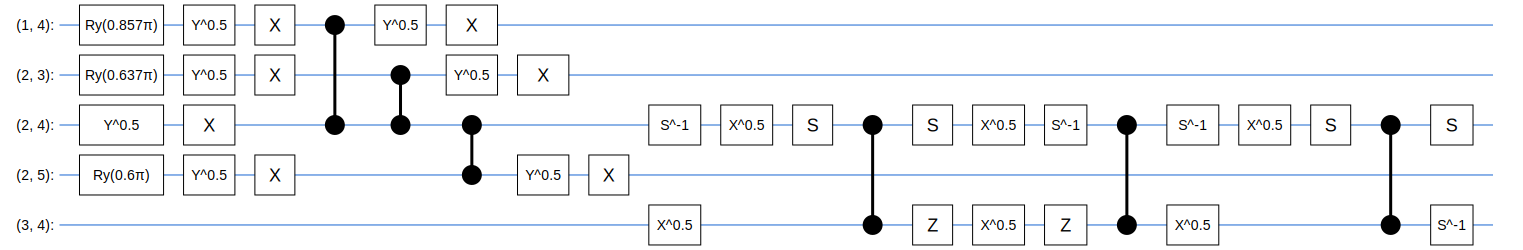

In [ ]:
SVGCircuit(get_model(n, 0))

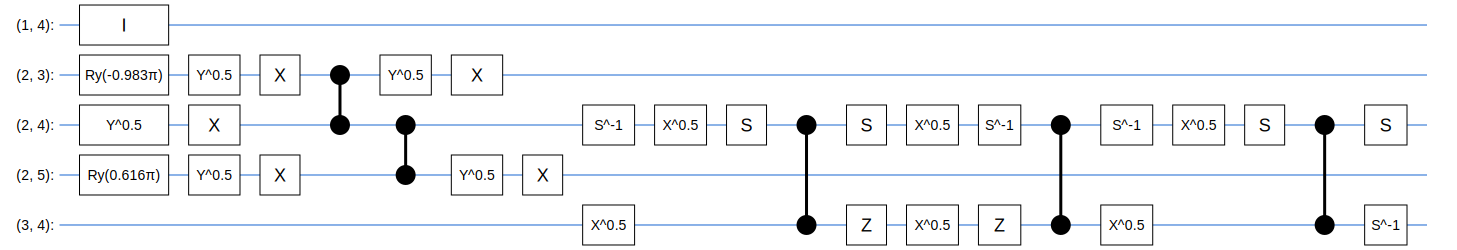

In [ ]:
SVGCircuit(get_model(n, 1))

Variational QRAM


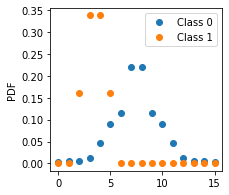

In [ ]:
simulator = cirq.Simulator()
qubit_order_0 = [cirq.GridQubit(2, 4), cirq.GridQubit(3, 4), cirq.GridQubit(1, 4), cirq.GridQubit(2, 3), cirq.GridQubit(2, 5)]
result = simulator.simulate(get_model(n, 0), qubit_order=qubit_order_0).final_state_vector
probs_class_0 = np.abs(result)**2

qubit_order_1 = [cirq.GridQubit(2, 4), cirq.GridQubit(1, 4), cirq.GridQubit(3, 4), cirq.GridQubit(2, 3), cirq.GridQubit(2, 5)]
result = simulator.simulate(get_model(n, 1), qubit_order=qubit_order_1).final_state_vector
probs_class_1 = np.abs(result)**2

print('Variational QRAM')
plt.figure(figsize=(3.2, 2.8))
plt.scatter(np.arange(2**n), probs_class_0[:2**n], label='Class 0')
plt.scatter(np.arange(2**n), probs_class_1[:2**n], label='Class 1')
plt.ylabel('PDF')
plt.legend()
plt.tight_layout()
plt.show()

### 1.3 Individual quantum data states

Later on, we'll benchmark a QNN trained over the dataset in superposition vs. a QNN trained with each data example individually (as in the original QNN paper by Farhi et al.). To encode individual bitstrings as quantum states, we use a binary encoding of $X$ gates.

In [ ]:
def convert_to_circuit(data, n):
    values = np.ndarray.flatten(data)
    qubits = get_exp_qubits(n)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        circuit.append(cirq.X(qubits[i])**value)
    return circuit

We can now translate our classical dataset into an array of quantum states, completing the dataset needed for the QNN benchmark.

In [ ]:
# helper function to replace np.unpackbits with a custom bitstring length
def unpackbits(x, num_bits):
    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits).reshape([1, num_bits])
    return np.flip((x & mask).astype(bool).astype(int).reshape(xshape + [num_bits]), axis=1)

all_data = np.array([unpackbits(data0.astype(np.int64), n), unpackbits(data1.astype(np.int64), n)])

x_circ = [convert_to_circuit(x, n) for x in all_data[0]] + [convert_to_circuit(x, n) for x in all_data[1]]
y = np.array([0]*len(all_data[0]) + [1]*len(all_data[1]))

## 2 Defining the QNN classifier

To evaluate the effectiveness of the variational QRAM, we train the QNN in two ways:
* Read each class of the dataset in superposition, allowing the QNN to classify *all* data examples of that class at once. Compute the loss over the entire class.
* Read each data example as individual quantum states, requiring the QNN to classify each example one by one. This corresponds to the original QNN proposed by Farhi et al.

Each QNN will be trained with an equal number of evaluations on the quantum device, and then we will compare the performance. First, a variational circuit is defined for the QNN to classify between two peaks. A hardware-efficient ansatz is used given the native gate basis.

In [ ]:
# define the QNN classifier
class ClassifierCircuitLayerBuilder():
    def __init__(self, data_qubits, readouts):
        self.data_qubits = data_qubits
        self.readouts = readouts
    
    def add_layer(self, circuit, prefix):
        for j, readout in enumerate(self.readouts):
            for i, qubit in enumerate(self.data_qubits):
                symbol = sympy.Symbol(prefix + '-' + str(j) + '-' + str(i))
                u = []
                u.extend([cirq.Z(qubit)**-0.5, cirq.X(qubit)**0.5, cirq.Z(qubit)**0.5])
                u.append(cirq.CZ(qubit, readout))
                u.extend([cirq.Z(qubit)**-1, cirq.X(qubit)**symbol, cirq.Z(qubit)**1])
                u.append(cirq.CZ(qubit, readout))
                u.extend([cirq.Z(qubit)**0.5, cirq.X(qubit)**0.5, cirq.Z(qubit)**-0.5])
                circuit += cirq.Circuit(u)

The QNN consists of one or more layers of parameterized gates as well as a readout qubit, which is measured to determine the predicted class of input data. In general, we can allow for more than one readout qubit.

In [ ]:
def build_quantum_classifier(n_readouts=1):
    """Create a QNN model circuit and readout operation to go along with it."""
    readouts = []
    qubits = get_exp_qubits(n)
    for i in range(n_readouts):
        readouts.append(qubits[-1])
    circuit = cirq.Circuit()
    data_qubits = qubits[:-1]
    
    # prepare the readout qubit
    circuit.append(cirq.X.on_each(readouts))
    circuit.append((cirq.Y**0.5).on_each(readouts))
    circuit.append(cirq.X.on_each(readouts))
    
    builder = ClassifierCircuitLayerBuilder(data_qubits, readouts)

    # add layer(s)
    builder.add_layer(circuit, "layer1")

    # prepare the readout qubit
    circuit.append((cirq.Y**0.5).on_each(readouts))
    circuit.append(cirq.X.on_each(readouts))

    total = cirq.Z(readouts[0])
    for readout in readouts[1:]:
        total += cirq.Z(readout)
    return circuit, total/len(readouts)

In [ ]:
# create the QNN classifier
model_circuit, model_readout = build_quantum_classifier(1)

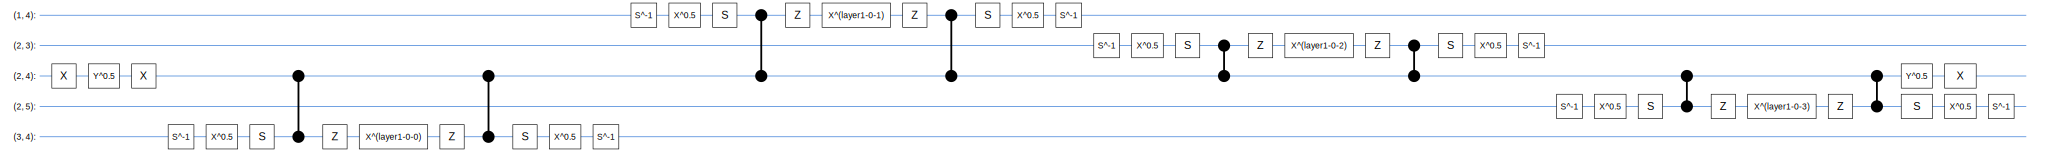

In [ ]:
SVGCircuit(model_circuit)

## 3 Training the QNN

### 3.1 Preparing for training

Since the expected readout qubit is in the range `[-1, 1]`, we choose a hinge loss to train the QNN.

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

To prepare the data, we convert our circuits into TensorFlow Quantum tensors, dividing the dataset into half for training and test data. Additionally, the class labels must be mapped to be either `-1` or `1` for the hinge loss.

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_circ[:size//2])
x_test_tfcirc = tfq.convert_to_tensor(x_circ[size//2:])
y_train = y[:size//2]
y_test = y[size//2:]

y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Finally, we can define a parameterized quantum circuit (`tfq.layers.PQC`) and minimize hinge loss in `tf.keras` using Adam. For the QNN that learns from individual examples in the dataset, the loss is computed over each example.

In [ ]:
epochs = 1

# train non-superposition QNN classifier
def train_sample_qnn(n, averages=5, learning_rate=0.001):
    sample_acc_data = []
    for i in range(averages):
        model = tf.keras.Sequential([
                # The input is the data-circuit, encoded as a tf.string
                tf.keras.layers.Input(shape=(), dtype=tf.string),
                # The PQC layer returns the expected value of the readout gate, range [-1,1].
                tfq.layers.PQC(model_circuit, model_readout, repetitions=10000, backend=backend),
        ])
        model.compile(
                loss=tf.keras.losses.Hinge(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=[hinge_accuracy])
    
        qnn_history_sample = model.fit(
                    x_train_tfcirc, y_train_hinge,
                    batch_size=1,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test_tfcirc, y_test_hinge))
    
        qnn_results_sample = model.evaluate(x_test_tfcirc, y_test)
        sample_weights = model.get_weights()[0]
        sample_acc_data.append(qnn_results_sample[1])
        print('Trained model', i+1)
        
    return sample_acc_data

For the QNN that learns from the QRAM superposition, the total number of quantum hardware evaluations is kept constant, causing an adjustment to the total number of epochs. Additionally, since the QNN outputs the average label of an entire class due to the linear superposition of data examples, the loss is computed over the entire class.

In [ ]:
# train superposition QNN classifier
def train_superpos_qnn(n, averages=5, learning_rate=0.001):
    gen_circuit_class_0 = get_model(n, 0)
    gen_circuit_class_1 = get_model(n, 1)
    superposition_acc_data = []
    for i in range(averages):
        model = tf.keras.Sequential([
                # The input is the data-circuit, encoded as a tf.string
                tf.keras.layers.Input(shape=(), dtype=tf.string),
                # The PQC layer returns the expected value of the readout gate, range [-1,1].
                tfq.layers.PQC(model_circuit, model_readout, repetitions=10000, backend=backend),
        ])
        model.compile(
                loss=tf.keras.losses.Hinge(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=[hinge_accuracy])

        x_superposition = tfq.convert_to_tensor([gen_circuit_class_0, gen_circuit_class_1])
        y_superposition = np.array([-1, 1])

        qnn_history_superposition = model.fit(
                    x_superposition, y_superposition,
                    batch_size=1,
                    epochs=epochs*len(x_train_tfcirc)//2,
                    verbose=0,
                    validation_data=(x_superposition, y_superposition))

        qnn_results_superposition = model.evaluate(x_test_tfcirc, y_test)
        superposition_weights = model.get_weights()[0]
        superposition_acc_data.append(qnn_results_superposition[1])
        print('Trained model', i+1)
        
    return superposition_acc_data

### 3.2 Evaluating the models

For simplicity, we take pre-computer hyperparameter parameter tunes of the learning rate previously obtained from Bayesian optimization. The two QNNs — trained by a superposition over the entire dataset or sampling individual examples — are then trained many times to determine the accuracy's mean and variance.

In [ ]:
# pre-optimized parameter tunes
lr_tunes = {'superposition': 10**-1.83, 'sample': 10**-3.93}

In [ ]:
averages = 20
superpos_qnn_data = train_superpos_qnn(n, averages=averages, learning_rate=lr_tunes['superposition'])
superpos_mean = np.mean(superpos_qnn_data)
superpos_std = np.std(superpos_qnn_data)/np.sqrt(averages)
print('QNN superposition accuracy (mean):', superpos_mean)
print('QNN superposition accuracy (stdev):', superpos_std)

6/6 [==============================] - 1s 60ms/step - loss: 0.6369 - hinge_accuracy: 0.6750
Trained model 1
6/6 [==============================] - 1s 66ms/step - loss: 0.4712 - hinge_accuracy: 0.8719
Trained model 2
6/6 [==============================] - 1s 70ms/step - loss: 0.6392 - hinge_accuracy: 0.6750
Trained model 3
6/6 [==============================] - 1s 67ms/step - loss: 0.7865 - hinge_accuracy: 0.6698
Trained model 4
6/6 [==============================] - 1s 70ms/step - loss: 0.5772 - hinge_accuracy: 0.6750
Trained model 5
6/6 [==============================] - 1s 73ms/step - loss: 0.9590 - hinge_accuracy: 0.4792
Trained model 6
6/6 [==============================] - 1s 71ms/step - loss: 0.6818 - hinge_accuracy: 0.7500
Trained model 7
6/6 [==============================] - 1s 81ms/step - loss: 0.7041 - hinge_accuracy: 0.6615
Trained model 8
6/6 [==============================] - 1s 79ms/step - loss: 0.6333 - hinge_accuracy: 0.6750
Trained model 9
6/6 [=======================

In [ ]:
sample_qnn_data = train_sample_qnn(n, averages=averages, learning_rate=lr_tunes['sample'])
sample_mean = np.mean(sample_qnn_data)
sample_std = np.std(sample_qnn_data)/np.sqrt(averages)
print('QNN sample accuracy (mean):', sample_mean)
print('QNN sample accuracy (stdev):', sample_std)

6/6 [==============================] - 1s 74ms/step - loss: 1.3611 - hinge_accuracy: 0.2458
Trained model 1
6/6 [==============================] - 1s 70ms/step - loss: 0.8586 - hinge_accuracy: 0.6719
Trained model 2
6/6 [==============================] - 1s 78ms/step - loss: 1.0331 - hinge_accuracy: 0.4448
Trained model 3
6/6 [==============================] - 1s 76ms/step - loss: 0.8689 - hinge_accuracy: 0.5250
Trained model 4
6/6 [==============================] - 1s 80ms/step - loss: 0.9726 - hinge_accuracy: 0.4729
Trained model 5
6/6 [==============================] - 1s 78ms/step - loss: 1.0333 - hinge_accuracy: 0.4167
Trained model 6
6/6 [==============================] - 1s 80ms/step - loss: 0.9244 - hinge_accuracy: 0.4188
Trained model 7
6/6 [==============================] - 1s 80ms/step - loss: 1.2292 - hinge_accuracy: 0.4208
Trained model 8
6/6 [==============================] - 1s 81ms/step - loss: 1.1388 - hinge_accuracy: 0.3406
Trained model 9
6/6 [=======================

As we can see, training the QNN with an approximate QRAM helped reduce the number of calls to quantum hardware required for the QNN to converge. Error bars show two standard deviations, and the dashed lines indicate random chance (50% accuracy) and full accuracy (100%). Note that 100% accuracy is impossible to achieve on this dataset due to the overlapped region between the two peaks.

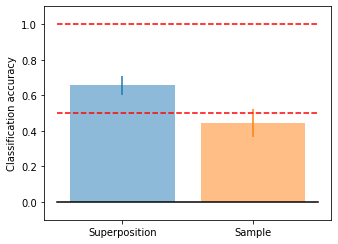

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 3.5))
ax.bar(0, superpos_mean, alpha=0.5)
ax.errorbar(0, superpos_mean, yerr=2*superpos_std, fmt='none')
ax.bar(1, sample_mean, alpha=0.5)
ax.errorbar(1, sample_mean, yerr=2*sample_std, fmt='none')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Superposition', 'Sample'])
ax.set_ylabel('Classification accuracy')
ax.set_ylim(-0.1, 1.1)
ax.plot([-0.5, 1.5], [0, 0], color='k')
ax.plot([-0.5, 1.5], [0.5, 0.5], 'r--')
ax.plot([-0.5, 1.5], [1, 1], 'r--')
plt.tight_layout()
plt.show()